# Rainfalls in Australia

In [1]:
#%matplotlib notebook
%matplotlib inline

In [2]:
import sys
import csv
import os

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy.sparse as ss
import scipy.stats as st

from signet.cluster import Cluster
import signet.utils as ut
from signet.utils import objscore
import matplotlib
#from mpl_toolkits.basemap import Basemap

In [3]:
direc = 'monthly_uncompressed/'

In [4]:
files = os.listdir(direc)

In [5]:
stat_lat_lon = []

with open(direc + 'HQMR_stations.txt','r') as f:
    for line in f:
        stat_lat_lon.append(line.split(' ')[0:3])


In [6]:

datal = []
for i, file in enumerate(files):
    if file[-5:] =='h.txt':
        data = pd.read_csv(direc+file, sep='   ', parse_dates=[])
        datal.append(data)

/home/songchaow/.conda/envs/PGT/lib/python3.6/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


In [7]:
datal[0].head()

,PRCP,Unnamed: 1,033073 18920101 20180131 missing_value=99999.9 WOODHOUSE
0,18920101 18920131,531.4,NaN
1,18920201 18920229,22.1,NaN
2,18920301 18920331,119.4,NaN
3,18920401 18920430,5.1,NaN
4,18920501 18920531,38.9,NaN


In [8]:
datal[0].columns

Index(['PRCP', 'Unnamed: 1',
       ' 033073 18920101 20180131 missing_value=99999.9 WOODHOUSE'],
      dtype='object')

In [9]:
# inde of stations
stations = []
for d in datal:
    c = d.columns[2].split()[0]
    stations.append(c)

In [10]:
d.columns[2]

' 017031 18850801 20141231 missing_value=99999.9 MARREE'

In [11]:
# drop useless columns

for d in datal:
    
    d.drop(columns=[d.columns[2]], inplace = True)

In [12]:
datal[0].head()

,PRCP,Unnamed: 1
0,18920101 18920131,531.4
1,18920201 18920229,22.1
2,18920301 18920331,119.4
3,18920401 18920430,5.1
4,18920501 18920531,38.9


In [13]:
# rename columns
for i,d in enumerate(datal):
    d.columns=["Date", "Rain_"+stations[i]]

In [14]:
datal[0].head()

,Date,Rain_033073
0,18920101 18920131,531.4
1,18920201 18920229,22.1
2,18920301 18920331,119.4
3,18920401 18920430,5.1
4,18920501 18920531,38.9


In [15]:
merge = datal[0]
for i in range(1, len(datal)):
    merge = pd.merge(merge, datal[i], on = 'Date', how = 'inner')
    #merge = pd.merge_asof(merge, datal[i], on = 'Date', left_index=True, right_index=True, direction='nearest')

In [16]:
merge.head()

,Date,Rain_033073,Rain_033035,Rain_077008,Rain_022000,Rain_080065,Rain_075012,Rain_058012,Rain_039040,Rain_099005,...,Rain_029032,Rain_036028,Rain_044054,Rain_007057,Rain_007049,Rain_017024,Rain_008141,Rain_086117,Rain_015085,Rain_017031
0,19690801 19690831,0.0,0.0,46.7,39.6,39.3,40.1,170.7,26.2,63.1,...,0.0,0.0,28.7,1.0,0.0,4.3,21.0,35.9,0.0,4.1
1,19690901 19690930,0.0,0.3,22.9,39.6,19.1,20.6,21.8,6.9,73.0,...,0.0,0.0,35.1,9.7,0.0,10.7,18.9,77.1,0.0,13.5
2,19691001 19691031,22.4,77.0,10.9,4.3,18.0,18.3,100.5,212.6,15.1,...,44.2,54.1,63.0,7.9,0.0,8.4,0.0,29.5,71.3,26.0
3,19691101 19691130,0.0,25.7,21.5,12.7,31.8,20.6,137.8,143.1,101.7,...,0.0,0.0,54.9,3.1,0.0,5.6,13.7,59.0,5.8,3.3
4,19691201 19691231,56.2,69.7,18.8,25.0,14.2,10.9,47.3,83.7,118.1,...,108.6,72.6,4.8,0.0,0.0,0.0,1.3,59.9,147.3,18.3


# Get correlation matrix

In [17]:
corr = np.array(merge.corr())

In [18]:
corr

array([[ 1.  ,  0.88, -0.08, ..., -0.04,  0.45,  0.19],
       [ 0.88,  1.  ,  0.01, ...,  0.02,  0.53,  0.25],
       [-0.08,  0.01,  1.  , ...,  0.58, -0.02,  0.25],
       ...,
       [-0.04,  0.02,  0.58, ...,  1.  , -0.08,  0.09],
       [ 0.45,  0.53, -0.02, ..., -0.08,  1.  ,  0.57],
       [ 0.19,  0.25,  0.25, ...,  0.09,  0.57,  1.  ]])

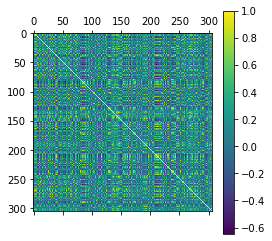

In [19]:
plt.matshow(corr)
plt.colorbar()

# Clustering

In [20]:
Ap = (corr + abs(corr))/2.
Am = (abs(corr)- corr)/2.
Aps = ss.csc_matrix(Ap)
Ams = ss.csc_matrix(Am)

perm=np.random.permutation(Ap.shape[0])
Aps=Aps[perm,:][:,perm]
Ams=Ams[perm,:][:,perm]

# ss.save_npz('plus_cc.npz', Aps)
# ss.save_npz('minus_cc.npz', Ams)

In [21]:
m = Cluster((Aps, Ams))

In [22]:
m.geproblem_adjacency(k = 9)

array([3, 4, 4, 1, 7, 6, 5, 3, 7, 0, 7, 5, 1, 3, 8, 5, 6, 8, 5, 8, 7, 0,
       5, 8, 5, 3, 3, 3, 3, 3, 7, 3, 5, 0, 4, 8, 1, 2, 5, 2, 7, 2, 2, 1,
       0, 7, 0, 8, 5, 4, 8, 0, 0, 7, 5, 7, 2, 8, 4, 4, 7, 7, 8, 3, 1, 8,
       5, 3, 7, 8, 4, 4, 5, 8, 5, 5, 3, 5, 5, 4, 4, 3, 5, 4, 1, 1, 0, 1,
       0, 4, 2, 4, 0, 8, 4, 5, 5, 8, 0, 3, 7, 1, 8, 0, 4, 7, 8, 1, 3, 6,
       5, 0, 5, 2, 3, 0, 8, 5, 0, 0, 3, 5, 0, 5, 4, 7, 5, 7, 7, 3, 6, 3,
       7, 0, 5, 3, 1, 3, 5, 2, 7, 2, 3, 8, 4, 7, 5, 8, 4, 3, 5, 1, 1, 4,
       8, 7, 8, 8, 0, 0, 5, 8, 2, 4, 1, 3, 7, 8, 4, 2, 4, 8, 4, 7, 3, 0,
       7, 1, 4, 5, 3, 8, 3, 8, 2, 4, 3, 5, 3, 4, 0, 7, 0, 7, 5, 4, 1, 7,
       5, 0, 8, 8, 7, 3, 4, 4, 0, 0, 8, 5, 5, 3, 2, 8, 1, 4, 1, 4, 1, 0,
       8, 8, 5, 4, 7, 8, 3, 4, 1, 2, 4, 2, 1, 3, 8, 1, 0, 8, 1, 8, 8, 4,
       5, 4, 1, 4, 5, 0, 8, 0, 8, 5, 2, 8, 5, 7, 1, 7, 8, 1, 2, 4, 5, 3,
       5, 3, 0, 1, 7, 6, 3, 1, 3, 3, 5, 8, 1, 3, 7, 0, 4, 2, 4, 1, 8, 3,
       1, 1, 8, 4, 2, 3, 6, 4, 1, 8, 7, 4, 8, 6, 3,

In [24]:
Ap

array([[1.  , 0.88, 0.  , ..., 0.  , 0.45, 0.19],
       [0.88, 1.  , 0.01, ..., 0.02, 0.53, 0.25],
       [0.  , 0.01, 1.  , ..., 0.58, 0.  , 0.25],
       ...,
       [0.  , 0.02, 0.58, ..., 1.  , 0.  , 0.09],
       [0.45, 0.53, 0.  , ..., 0.  , 1.  , 0.57],
       [0.19, 0.25, 0.25, ..., 0.09, 0.57, 1.  ]])

In [25]:
Aps.shape

(306, 306)